In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


Want to compare my best ML algorithm results to a Neural Network

In [2]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [3]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [4]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))

66501


In [5]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

In [6]:
features.columns

Index(['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'],
      dtype='object')

Scale all features using the quantile transformation (including the new features added during the benchmark refinement phase)

In [7]:
features.dtypes

reward              float64
difficulty          float64
duration            float64
mobile              float64
social              float64
web                 float64
bogo                  uint8
discount              uint8
informational         uint8
age                   int64
became_member_on      int64
income              float64
female                uint8
male                  uint8
other                 uint8
total_spend         float64
transaction           uint8
viewed                uint8
dtype: object

In [8]:
features=features.astype(float)

features=quantileScale(features, ['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'])

features=features.values


In [9]:
#Convert features and labels to tensors
features = torch.as_tensor(features, dtype=torch.float)
labels = torch.as_tensor(labels, dtype=torch.long)

In [10]:
## Split data into three random datasets 

# Generate randomic indices
len_dataset = len(features)
random_idx = np.random.choice(len_dataset, len_dataset, replace=False)

# Use the proportions: train: 70%, valid: 15%, test: 15%
train_idx = random_idx[:int(len_dataset*0.70)]
valid_idx = random_idx[-int(len_dataset*0.15):]
test_idx = random_idx[int(len_dataset*0.70):-int(len_dataset*0.15)]

# Create datasets
train_dataset = TensorDataset(features[train_idx], labels[train_idx])
valid_dataset = TensorDataset(features[valid_idx], labels[valid_idx])
test_dataset = TensorDataset(features[test_idx], labels[test_idx])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Making sure the split has maintained balanced classes

In [11]:
#Counting the training labels
train_neg = (labels[train_idx] == 0).sum()
train_pos = (labels[train_idx] == 1).sum()
train_total=len(train_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(train_neg, train_pos, train_neg/train_total, train_pos/train_total))

#Counting the validating labels
valid_neg = (labels[valid_idx] == 0).sum()
valid_pos = (labels[valid_idx] == 1).sum()
valid_total =len(valid_idx)
print('Validation data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(valid_neg, valid_pos, valid_neg/valid_total, valid_pos/valid_total))

#Counting the testing labels
test_neg = (labels[test_idx] == 0).sum()
test_pos = (labels[test_idx] == 1).sum()
test_total =len(test_idx)
print('Testing data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(test_neg, test_pos, test_neg/test_total, test_pos/test_total))


Training data has 26729 unsuccessful events and 19821 successful events 
The ratio between classes is:	 0.57 : 0.43

Validation data has 5678 unsuccessful events and 4297 successful events 
The ratio between classes is:	 0.57 : 0.43

Testing data has 5656 unsuccessful events and 4320 successful events 
The ratio between classes is:	 0.57 : 0.43



In [12]:
class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128,128],
                 output_size=2, dropout=0.2):
        super(LinearNN, self).__init__()
        self.input_size = input_size

        nodes = []
        nodes.append(input_size)
        nodes.extend(hidden_layers)
        nodes.append(output_size)

        self.module_list = nn.ModuleList()
        for nodes_in, nodes_out in zip(nodes[:-1], nodes[1:]):
            layer = nn.Linear(nodes_in, nodes_out)
            self.module_list.append(layer)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.module_list[:-1]:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.module_list[-1](x)

        return x

In [13]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, labels in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            valid_loss += criterion(prediction, labels)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(labels.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        con_mat = confusion_matrix(y_true, y_pred)
        class_report=classification_report(y_true, y_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False)
        
        model.train()

        return valid_loss, con_mat, class_report
    


In [14]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=200):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, labels) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalidation loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Only save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

In [15]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256])

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(train_pos)), 1])) 

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15)

In [16]:
%%time 
#100 takes 12min 8s
#200 takes 27min 9s

linear_loss = train(NNclassifier, model_name='NN_classifier', epochs=60)

Epoch    1	train loss:  0.5880	validation loss:  0.5675
Epoch    2	train loss:  0.5673	validation loss:  0.5602
Epoch    3	train loss:  0.5614	validation loss:  0.5557
Epoch    4	train loss:  0.5577	validation loss:  0.5509
Epoch    5	train loss:  0.5538	validation loss:  0.5482
Epoch    6	train loss:  0.5509	validation loss:  0.5462
Epoch    7	train loss:  0.5493	validation loss:  0.5457
Epoch    8	train loss:  0.5464	validation loss:  0.5427
Epoch    9	train loss:  0.5453	validation loss:  0.5425
Epoch   10	train loss:  0.5446	validation loss:  0.5415
Epoch   11	train loss:  0.5431	validation loss:  0.5402
Epoch   12	train loss:  0.5424	validation loss:  0.5401
Epoch   13	train loss:  0.5405	validation loss:  0.5386
Epoch   14	train loss:  0.5399	validation loss:  0.5384
Epoch   15	train loss:  0.5399	validation loss:  0.5398
Epoch   16	train loss:  0.5387	validation loss:  0.5383
Epoch   17	train loss:  0.5377	validation loss:  0.5373
Epoch   18	train loss:  0.5374	validation loss: 

In [17]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [18]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.6998    0.8502    0.7677      5656
  successful     0.7271    0.5225    0.6080      4320

    accuracy                         0.7083      9976
   macro avg     0.7135    0.6864    0.6879      9976
weighted avg     0.7116    0.7083    0.6986      9976



<Axes: >

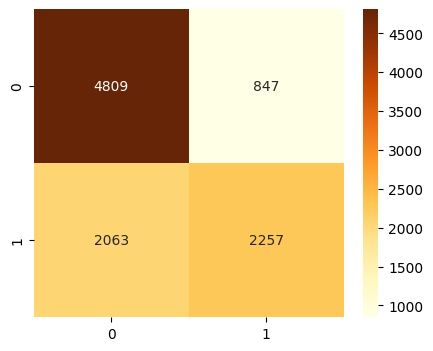

In [19]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

<font size=4>Refinement and Optimising for Recall<font/>

weighting train_pos by 1.35

In [20]:
NNclassifier = LinearNN(input_size=18, output_size=2, hidden_layers=[256,256,256])

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(1.35*train_pos)), 1])) 

optimizer = torch.optim.Adam(NNclassifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=15)

In [21]:
%%time 
#200 takes 16min 35s

linear_loss = train(NNclassifier, model_name='NNclassifier', epochs=60)

Epoch    1	train loss:  0.6120	validation loss:  0.5959
Epoch    2	train loss:  0.5919	validation loss:  0.5817
Epoch    3	train loss:  0.5854	validation loss:  0.5754
Epoch    4	train loss:  0.5812	validation loss:  0.5730
Epoch    5	train loss:  0.5771	validation loss:  0.5706
Epoch    6	train loss:  0.5752	validation loss:  0.5705
Epoch    7	train loss:  0.5723	validation loss:  0.5656
Epoch    8	train loss:  0.5698	validation loss:  0.5657
Epoch    9	train loss:  0.5695	validation loss:  0.5641
Epoch   10	train loss:  0.5674	validation loss:  0.5634
Epoch   11	train loss:  0.5666	validation loss:  0.5657
Epoch   12	train loss:  0.5654	validation loss:  0.5636
Epoch   13	train loss:  0.5643	validation loss:  0.5616
Epoch   14	train loss:  0.5631	validation loss:  0.5602
Epoch   15	train loss:  0.5623	validation loss:  0.5609
Epoch   16	train loss:  0.5620	validation loss:  0.5602
Epoch   17	train loss:  0.5611	validation loss:  0.5600
Epoch   18	train loss:  0.5601	validation loss: 

In [22]:
#evaluation metrics
loss, con_mat, class_report=  validate(NNclassifier, test_dataloader)

In [23]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7271    0.7910    0.7577      5656
  successful     0.6908    0.6113    0.6487      4320

    accuracy                         0.7132      9976
   macro avg     0.7090    0.7012    0.7032      9976
weighted avg     0.7114    0.7132    0.7105      9976



<Axes: >

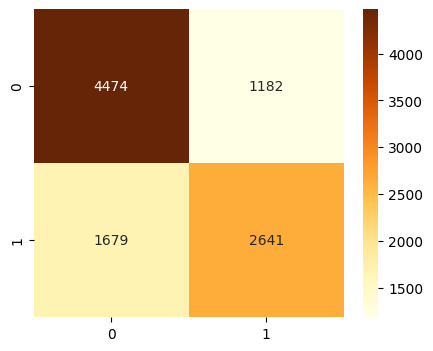

In [24]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

In [ ]:
# Benchmark 
#Best parameters for recall found on training set are:
#{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
#
#precision    recall  f1-score   support

#unsuccessful     0.7303    0.7918    0.7598      5677
#  successful     0.6907    0.6139    0.6500      4299

#    accuracy                         0.7151      9976
#   macro avg     0.7105    0.7028    0.7049      9976
#weighted avg     0.7132    0.7151    0.7125      9976